# Task 1: Database (re)design



You are working with a trading company. The manager approached you to redesign the database. They have already 3 relations that represent 3 main entities:

  bill(bill_id, branch_id, amount, ...)
  customer(customer_id, street, house_number, city, country, ...)
  partner(company_name, country, products_and_services, ...)

**1a) Add more attributes to the given relations (bill, customer, partner).**

**Bill Table / Relation:**
bill(
    bill_id,
    branch_id,
    amount,
    bill_date,
    payment_status,
    currency
)

**Customer Table / Relation:**
customer(
customer_id,
    street,
    house_number,
    city,
    country,
    phone,
    email,
    customer_type
)

**Partner** Table / Relation:**
 company_name,
    country,
    products_and_services,
    contact_person,
    phone,
    partner_type
)

In deciding which attributes to add to the given relations, we considered what information would be most important for tracking transactions or bills in a trading company. For the bill relation, although a unique identifier (bill_id) and the amount already existed, there was no additional information to support tracking the progress or history of bills. We therefore added bill_date, payment_status, and currency, as these attributes allow bills to be monitored over time, their payment status recorded, and amounts clearly interpreted within the correct currency. Without specifying the currency, the data could easily lead to significant errors.

For the customer relation, we found that the existing attributes covered some basic details, but further information such as phone, email, and customer_type would be highly beneficial. These additions enable more reliable communication with customers and provide a clearer understanding of the different types of relationships the company maintains.

Finally, for the partner relation, the existing attributes described the company in general, including the company_name, but did not indicate who should be contacted directly. To address this, we added an attribute for a contact person, ensuring that there is a responsible individual at each company who can be reached regarding trades.

**1b) Add a minimum of two relations that represent entities. Make sure that there is at least one many-to-many relationship between the entities.**

product(
    product_id,
    product_name,
    description,
    unit_price,
    stock_quantity,
    category,
    company_name
)

order_table(
    order_id,
    customer_id,
    order_date,
    status,
    total_amount,
    bill_id
)

order_product(
    order_id,
    product_id,
    quantity,
    unit_price
)

To prevent confusion and loss of traceability around trades, we introduced three relations that model how the business actually sells things and how those sales are tied back to customers, partners, and bills. First, we added a relation for product. While the original schema let us list partners and their offerings, it didn’t give us a concrete, uniquely identifiable item we could price, stock, and reference in orders. The product(product_id, product_name, description, unit_price, stock_quantity, category, company_name) table does exactly that: each product has an identifier, and additional commercial details (name, description, list price, category, stock_quantity), and a foreign key to the Partner relation using company_name. This link lets us see who supplies what, run supplier analyses, and ensure data consistency

Next, we added an Order relation to represent the transaction with a customer over time: order_table(order_id, customer_id, order_date, status, total_amount, bill_id). In this table, customer_id ties each order to the customer who placed it, while order_date and status capture the timeline and state of the trade (e.g., paid, pending, overdue, cancelled). We included total_amount for fast reporting and link to Bill via bill_id so financial information can be tied to orders and payment status.

Finally, to satisfy the requirement for a many-to-many relationship, we modeled the fact that one order can contain many products and the same product can appear in many different orders. We introduced the junction table Order_Product: order_product(order_id, product_id, quantity, unit_price). This intersection entity resolves the many-to-many between Order and Product, keeping track of the quantity and the unit_price. Storing unit_price here is deliberate, it preserves a historical price for each line item (even if the product’s list price changes).

1c) https://drawsql.app/teams/databoysss/diagrams/assignment1-data-wrangling

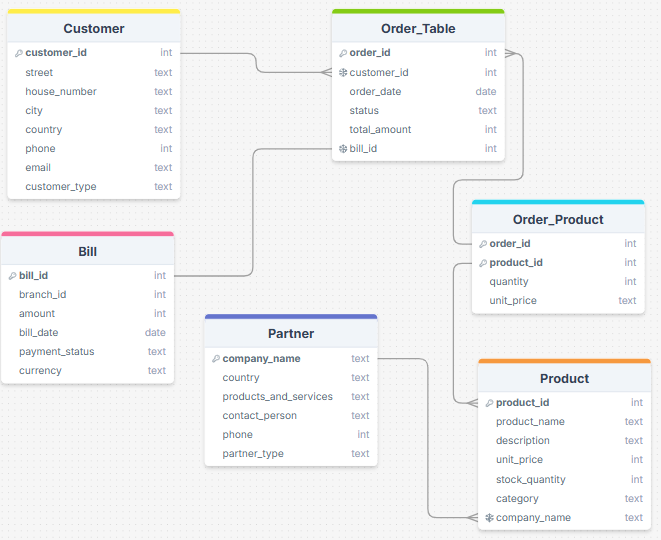

**1d) Identify the cardinalities of the relationships between the entities and explain how you can represent the relationships in your design.**


**Cardinalities:**

- Customer → Order: 1:M (One customer can place many orders)

- Order → Bill: 1:1 (Each order creates one bill)

- Partner → Product: 1:M (One partner can supply many products)

- Order ↔ Product: M:M (Many-to-many through Order_Product junction table)


**Relationship Representation:**

- 1:M relationships: Represented by placing foreign key in the "many" side
- 1:1 relationships: Foreign key placed in Order table
- M:M relationships: Represented using a junction table (Order_Product) with foreign keys from both related tables as composite primary key

**1e) List all the primary-key-foreign-key constraints in the database.**


**Primary Keys:**

- customer(customer_id)
- partner(company_name)
- product(product_id)
- order_table(order_id)
- bill(bill_id)
- order_product(order_id, product_id) - Composite PK

**Foreign Key Constraints:**

- order_table.customer_id → customer.customer_id
- order_table.bill_id → bill.bill_id
- product.partner_id → partner.company_name
- order_product.order_id → order_table.order_id
- order_product.product_id → product.product_id

**1f) Write the SQL code that creates the whole database in SQLite and save the file as .sql that can be run directly from the sqlite3 bash using the command .read my_file.sql**



In [ ]:

CREATE TABLE Customer (
  customer_id INTEGER PRIMARY KEY,
  street TEXT,
  house_number INTEGER,
  city TEXT,
  country TEXT,
  phone INTEGER,
  email TEXT UNIQUE,
  customer_type TEXT);

CREATE TABLE Bill (
  bill_id INTEGER PRIMARY KEY,
  branch_id INTEGER,
  amount DECIMAL(15,2) NOT NULL CHECK (amount >= 0),
  bill_date DATE NOT NULL DEFAULT CURRENT_DATE,
  payment_status TEXT CHECK (payment_status IN ('Paid', 'Pending', 'Overdue', 'Cancelled')) DEFAULT 'Pending',
  currency TEXT);

CREATE TABLE Partner (
  company_name TEXT PRIMARY KEY,
  country TEXT,
  products_and_services TEXT,
  contact_person TEXT,
  phone INTEGER,
  partner_type TEXT);

CREATE TABLE Product (
  product_id INTEGER PRIMARY KEY,
  product_name TEXT,
  description TEXT,
  unit_price NUMERIC,
  stock_quantity INTEGER,
  category TEXT,
  company_name TEXT,
  FOREIGN KEY (company_name) REFERENCES Partner(company_name)
    ON UPDATE CASCADE ON DELETE SET NULL);

CREATE TABLE Order_table (
  order_id INTEGER PRIMARY KEY,
  customer_id INTEGER,
  order_date DATE NOT NULL DEFAULT CURRENT_DATE,
  status TEXT,
  total_amount DECIMAL(15,2) DEFAULT 0.00 CHECK (total_amount >= 0),
  bill_id INTEGER UNIQUE,
  FOREIGN KEY (customer_id) REFERENCES Customer(customer_id)
    ON UPDATE CASCADE ON DELETE CASCADE,
  FOREIGN KEY (bill_id) REFERENCES Bill(bill_id)
    ON UPDATE CASCADE ON DELETE SET NULL);

CREATE TABLE Order_product (
  order_id INTEGER,
  product_id INTEGER,
  quantity INTEGER NOT NULL CHECK (quantity > 0),
  unit_price DECIMAL(10,2) NOT NULL CHECK (unit_price >= 0),
  PRIMARY KEY (order_id, product_id),
  FOREIGN KEY (order_id) REFERENCES Order_table(order_id)
    ON UPDATE CASCADE ON DELETE CASCADE,
  FOREIGN KEY (product_id) REFERENCES Product(product_id)
    ON UPDATE CASCADE ON DELETE CASCADE);


INSERT INTO Customer VALUES
(1, 'Main St', 101, 'Amsterdam', 'Netherlands', 312345678, 'alice@example.com', 'Retail'),
(2, 'Baker St', 221, 'London', 'UK', 447123456, 'bob@example.com', 'Wholesale'),
(3, 'Wall St', 12, 'New York', 'USA', 12125551212, 'carol@example.com', 'Retail'),
(4, 'Rue de Rivoli', 45, 'Paris', 'France', 33123456789, 'dave@example.com', 'Retail'),
(5, 'Königsallee', 88, 'Düsseldorf', 'Germany', 4915112345678, 'eve@example.com', 'Wholesale'),
(6, 'Via Roma', 33, 'Rome', 'Italy', 390612345678, 'frank@example.com', 'Retail'),
(7, 'Gran Vía', 77, 'Madrid', 'Spain', 34911234567, 'grace@example.com', 'Retail'),
(8, 'Kurfürstendamm', 99, 'Berlin', 'Germany', 4917612345678, 'heidi@example.com', 'Wholesale'),
(9, 'Champs-Élysées', 10, 'Paris', 'France', 33198765432, 'ivan@example.com', 'Retail'),
(10, 'Oxford St', 55, 'London', 'UK', 447987654321, 'judy@example.com', 'Wholesale');


INSERT INTO Bill VALUES
(1, 101, 2500.00, '2025-09-01', 'Paid', 'EUR'),
(2, 102, 1800.50, '2025-09-02', 'Pending', 'USD'),
(3, 103, 3200.75, '2025-09-03', 'Overdue', 'GBP'),
(4, 104, 1500.00, '2025-09-04', 'Cancelled', 'EUR'),
(5, 105, 2750.25, '2025-09-05', 'Paid', 'USD'),
(6, 106, 1999.99, '2025-09-06', 'Paid', 'EUR'),
(7, 107, 3050.00, '2025-09-07', 'Pending', 'USD'),
(8, 108, 4100.00, '2025-09-08', 'Paid', 'GBP'),
(9, 109, 950.00, '2025-09-09', 'Overdue', 'EUR'),
(10, 110, 1200.00, '2025-09-10', 'Cancelled', 'USD');


INSERT INTO Partner VALUES
('TechNova', 'USA', 'Laptops, Monitors', 'John Smith', 12125550001, 'Supplier'),
('GreenFarm', 'Netherlands', 'Organic Produce', 'Anna Vermeer', 31201234567, 'Distributor'),
('AutoPartsCo', 'Germany', 'Car Parts', 'Hans Müller', 4915112345678, 'Manufacturer'),
('StyleWear', 'France', 'Clothing', 'Claire Dubois', 33123456789, 'Retailer'),
('ByteWorks', 'UK', 'Software Solutions', 'James Bond', 447123456789, 'Supplier');


INSERT INTO Product VALUES
(1, 'Laptop X1', 'High-end business laptop', 1200.00, 50, 'Electronics', 'TechNova'),
(2, 'Monitor 24"', 'Full HD monitor', 200.00, 100, 'Electronics', 'TechNova'),
(3, 'Organic Apples', 'Fresh from farm', 3.50, 500, 'Food', 'GreenFarm'),
(4, 'Brake Pads', 'Durable brake pads', 45.00, 300, 'Automotive', 'AutoPartsCo'),
(5, 'Jeans Slim Fit', 'Stylish denim jeans', 60.00, 200, 'Apparel', 'StyleWear'),
(6, 'CRM Suite', 'Customer management software', 1500.00, 20, 'Software', 'ByteWorks'),
(7, 'T-Shirt Classic', 'Cotton t-shirt', 20.00, 300, 'Apparel', 'StyleWear'),
(8, 'Engine Oil', 'Synthetic motor oil', 35.00, 150, 'Automotive', 'AutoPartsCo'),
(9, 'Bananas', 'Organic bananas', 2.00, 400, 'Food', 'GreenFarm'),
(10, 'Tablet Z', '10-inch tablet', 350.00, 80, 'Electronics', 'TechNova');


INSERT INTO Order_table VALUES
(1, 1, '2025-09-10', 'Shipped', 2400.00, 1),
(2, 2, '2025-09-11', 'Processing', 1800.50, 2),
(3, 3, '2025-09-12', 'Delivered', 3200.75, 3),
(4, 4, '2025-09-13', 'Cancelled', 0.00, 4),
(5, 5, '2025-09-14', 'Delivered', 2750.25, 5),
(6, 6, '2025-09-15', 'Processing', 1999.99, 6),
(7, 7, '2025-09-16', 'Shipped', 3050.00, 7),
(8, 8, '2025-09-17', 'Delivered', 4100.00, 8),
(9, 9, '2025-09-18', 'Pending', 950.00, 9),
(10, 10, '2025-09-19', 'Cancelled', 0.00, 10);

INSERT INTO Order_product VALUES
(1, 1, 2, 1200.00),
(2, 2, 9, 200.00),
(3, 3, 100, 3.50),
(3, 4, 20, 45.00),
(5, 5, 30, 60.00),
(5, 6, 1, 1500.00),
(6, 7, 10, 20.00),
(6, 8, 5, 35.00),
(7, 9, 50, 2.00),
(8, 10, 10, 350.00);


SyntaxError: invalid syntax (ipython-input-1803013773.py, line 1)

**1g) Analyzing the table order_product if in Boyce-Codd Normal Form (BCNF)**

**Functional Dependencies:**

- (order_id, product_id) → quantity

- (order_id, product_id) → unit_price

The table is in 1NF as it has atomic values and each roq is identified by the composite primary key.

The table is in 2NF as there are no partial dependencies as both Quanitiy and unit price depend on the composite key

The table is in 3NF as there are no transitive dependies as no non-key attributes depend on other non key attributes.

All dependencies depend on(order_id, product_id) which is the primary key and therefore a superkey as a determinant. Therefore the table is in BCNF as it satisfies all normal forms




# Task 2: Querying the Database

Using the database from Task 1, write queries in natural language, relational algebra and SQL that contains:

**2a) Joining more than two tables: Show customer names, their orders, and bill information**

π_{email, order_id, order_date, amount, currency, payment_status}
  ( (Customer ⨝_{C.customer_id = O.customer_id} Order)
    ⨝_{O.bill_id = B.bill_id} Bill )


SELECT
    c.email,
    o.order_id,
    o.order_date,
    b.amount,
    b.currency,
    b.payment_status

FROM customer c

JOIN order_table o ON c.customer_id = o.customer_id

JOIN bill b ON o.bill_id = b.bill_id;

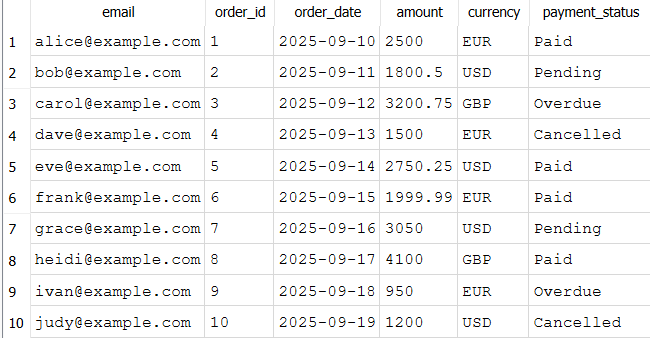


**2b) Aggregate function:  Count the total number of customers in each country**

γ_{country; COUNT(*) → customer_count}(Customer)


SELECT
    country,
    COUNT(*) as customer_count
FROM customer
GROUP BY country;

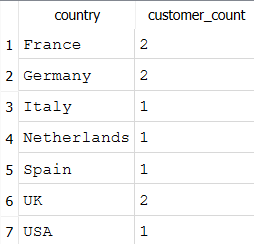

**2c) Nested query: Find customers who have placed orders**

π_{customer_id, email, city, country} (σ_{customer_id ∈ π_{customer_id}(Order)} (Customer))


SELECT
    customer_id,
    email,
    city,
    country

FROM customer

WHERE customer_id IN (
    SELECT customer_id
    FROM order_table);

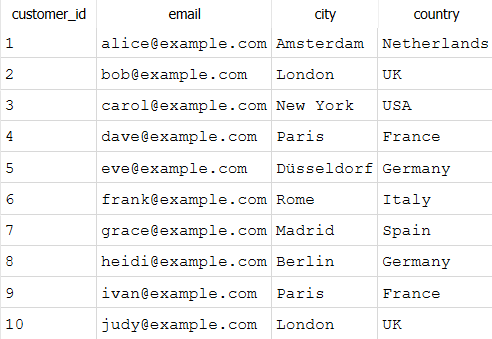

# Task 3: Data extraction and entity resolution using Python

Using the database from Task 1, perform the following tasks using Python code:

**a) Write a Python code that allows you to connect to the database file, send SQL queries to the database and extract the results.**


**Steps**

We connect to our *trading.db* database and execute two targeted SQL queries. First, we retrieve all *customers* from the Netherlands, selecting only their *ID*, *email*, and *customer type*.

We then fetch all *electronics* products with their *ID*, *name*, *price*, and *stock quantity*. We store each result in separate DataFrames - one for Dutch customers and another for electronics inventory.

Finally, we display both tables neatly formatted and close the database connection.

In [ ]:
import sqlite3
import pandas as pd

# Connect to the database
conn = sqlite3.connect('trading.db')

# First query: Customers from Netherlands
first_query = """
SELECT customer_id, email, customer_type
FROM Customer
WHERE country = 'Netherlands';
"""

# Second query: Products in the Electronics category
second_query = """
SELECT product_id, product_name, unit_price, stock_quantity
FROM Product
WHERE category = 'Electronics';
"""

# Execute both queries
df_customers = pd.read_sql_query(first_query, conn)
df_electronics = pd.read_sql_query(second_query, conn)

# Display results
print("Customers from Netherlands:")
print(df_customers)

print("\nElectronics Products:")
print(df_electronics)

# Close the connection
conn.close()


DatabaseError: Execution failed on sql '
SELECT customer_id, email, customer_type
FROM Customer
WHERE country = 'Netherlands';
': no such table: Customer

**b) Read the content of the customer relation (table) into Pandas DataFrame.**

**Steps**:

We import *sqlite3* and *pandas* to connect to our database and analyze data. We then establish a connection to our database *'trading.db'* and use a SQL query to load the entire *Customer* table into a pandas DataFrame. This converts the structured database records into a flexible table format perfect for analysis.

Afterwards, we display the DataFrame to inspect all customer data and finally close the database connection to maintain proper resource management.

In [ ]:
import sqlite3
import pandas as pd

# Connect to the database
conn = sqlite3.connect('trading.db')

# Read the Customer table into a DataFrame
df_customer = pd.read_sql_query("SELECT * FROM Customer", conn)

# Display the DataFrame
print(df_customer)

# Close the connection
conn.close()


DatabaseError: Execution failed on sql 'SELECT * FROM Customer': no such table: Customer

**3c) Using a similarity function that compares two records (similar to the one in the tutorial), report the customers with similarity > 0.7.**

**Steps**

We start by importing the *sqlite3* library to work with our database. Then we define a function called *compare_two_customers* that takes two customer records as input. Inside this function, we create profiles for each customer by converting their attributes (*customer type*, *city*, and *country*) into sets of features.

Next, we calculate the similarity between these two customers by finding how many features they have in common and dividing by the total number of unique features they share - this is called Jaccard similarity.We also compute the similarity of their email addresses using Jaro similarity, which measures the similarity between two strings match. Both values are then combined into a single similarity score.

 After defining our comparison function, we connect to our *trading.db* database and fetch all customer records.

We then use two loops to compare every possible pair of customers. For each pair, we call our comparison function and if the similarity score is *greater than 0.7* (70%), we save that pair to our results list.

Finally, we display all the similar customer pairs we found, showing their *email addresses*, *locations*, and exact *similarity percentages*. If no highly similar pairs are found, we simply inform the user that no matches met our threshold.



In [ ]:
import sqlite3

def jaro(s, t):
    s_len, t_len = len(s), len(t)

    if s_len == 0 and t_len == 0:
        return 1.0

    match_distance = max(s_len, t_len) // 2 - 1

    s_matches = [False] * s_len
    t_matches = [False] * t_len

    matches = 0
    transpositions = 0

    # Step 1: Find matches
    for i in range(s_len):
        start = max(0, i - match_distance)
        end = min(i + match_distance + 1, t_len)
        for j in range(start, end):
            if t_matches[j]:
                continue
            if s[i] != t[j]:
                continue
            s_matches[i] = True
            t_matches[j] = True
            matches += 1
            break

    if matches == 0:
        return 0.0

    # Step 2: Count transpositions
    s_m = []
    t_m = []
    for i in range(s_len):
        if s_matches[i]:
            s_m.append(s[i])
    for j in range(t_len):
        if t_matches[j]:
            t_m.append(t[j])

    for i in range(len(s_m)):
        if s_m[i] != t_m[i]:
            transpositions += 1

    transpositions //= 2

    # Step 3: Apply formula
    return (matches / s_len + matches / t_len + (matches - transpositions) / matches) / 3.0

def compare_two_customers(customer1, customer2):
    # Create profiles for each customer
    profile1 = {
        f"type_{customer1[2]}",
        f"city_{customer1[3]}",
        f"country_{customer1[4]}"
    }

    profile2 = {
        f"type_{customer2[2]}",
        f"city_{customer2[3]}",
        f"country_{customer2[4]}"
    }

# Jaro similarity on email
    email_similarity = jaro(customer1[1], customer2[1])


    # similarity calculation
    common_features = len(profile1 & profile2)
    total_features = len(profile1 | profile2)

    if total_features > 0:
        jaccard = common_features / total_features
    else:
        jaccard = 0

    # Combine Jaro and Jaccard similarities
    overall_similarity = (email_similarity + jaccard) / 2
    return overall_similarity


# Connect to database
conn = sqlite3.connect(DB_PATH)
customers = conn.execute("SELECT customer_id, email, customer_type, city, country FROM Customer").fetchall()
conn.close()

print("COMPARING CUSTOMERS (2 at a time):\n")


# Compare each pair of customers using our function
similar_pairs = []

for i in range(len(customers)):
    for j in range(i + 1, len(customers)):
        # Get two customers to compare
        cust1 = customers[i]
        cust2 = customers[j]

        # Use our function to compare exactly 2 records
        similarity = compare_two_customers(cust1, cust2)

        # Only keep pairs that are very similar
        if similarity > 0.7:
            similar_pairs.append((cust1, cust2, similarity))

# Show results
if similar_pairs:
    print(f"Found {len(similar_pairs)} similar pairs:")
    print("-" * 40)

    for cust1, cust2, score in similar_pairs:
        print(f"Customer 1: {cust1[1]} ({cust1[3]}, {cust1[2]})")
        print(f"Customer 2: {cust2[1]} ({cust2[3]}, {cust2[2]})")
        print(f"Similarity: {score:.2f} ({score * 100:.0f}% similar)")
        print()
else:
    print("No customer pairs found with similarity > 0.7")



NameError: name 'DB_PATH' is not defined